In [94]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import holidays
from datetime import timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.linear_model import LinearRegression


In [2]:
retail_data = pd.read_csv('retail_data.csv')
pd.set_option('display.max_columns', None)
retail_data.head(10)

,Order No,Order Date,Customer Name,Address,City,State,Customer Type,Account Manager,Order Priority,Product Name,Product Category,Product Container,Ship Mode,Ship Date,Cost Price,Retail Price,Profit Margin,Order Quantity,Sub Total,Discount %,Discount $,Order Total,Shipping Cost,Total
0,4293-1,02-09-2014,Vivek Sundaresam,"152 Bunnerong Road,Eastgardens",Sydney,NSW,Small Business,Tina Carlton,Critical,UGen Ultra Professional Cordless Optical Suite,Office Supplies,Small Box,Regular Air,04-09-2014,$156.50,$300.97,$144.47,23.0,"$4,533.52",2%,$194.83,"$4,757.22",$7.18,"$4,291.55"
1,5001-1,24-10-2015,Shahid Hopkins,"438 Victoria Avenue,Chatswood",Sydney,NSW,Corporate,Natasha Song,Medium,Bagged Rubber Bands,Office Supplies,Small Pack,Regular Air,26-10-2015,$0.24,$1.26,$1.02,8.0,$45.20,3%,$0.00,$45.90,$0.70,$46.91
2,5004-1,13-03-2014,Dennis Pardue,"412 Brunswick St,Fitzroy",Melbourne,VIC,Consumer,Connor Betts,Not Specified,TechSavi Cordless Navigator Duo,Office Supplies,Small Box,Regular Air,13-03-2014,$42.11,$80.98,$38.87,45.0,$873.32,4%,$72.23,$837.57,$7.18,$82.58
3,5009-1,18-02-2013,Sean Wendt,"145 Ramsay St,Haberfield",Sydney,NSW,Small Business,Phoebe Gour,Critical,Artisan Printable Repositionable Plastic Tabs,Office Supplies,Wrap Bag,Regular Air,20-02-2013,$5.33,$8.60,$3.27,16.0,$73.52,1%,$4.35,$740.67,$6.19,$730.92
4,5010-1,13-09-2014,Christina Vanderzanden,"188 Pitt Street,Sydney",Sydney,NSW,Small Business,Tina Carlton,Not Specified,Pizazz Drawing Pencil Set,Office Supplies,Wrap Bag,Express Air,17-09-2014,$1.53,$2.78,$1.25,49.0,$138.46,7%,$5.95,$123.77,$1.34,$125.97
5,5011-1,24-11-2013,Patrick OBrill,"53 Riley Street,Woolloomooloo",Sydney,NSW,Home Office,Tina Carlton,Not Specified,"Alto Parchment Paper, Assorted Colors",Office Supplies,Wrap Bag,Regular Air,26-11-2013,$4.59,$7.28,$2.69,45.0,$197.36,8%,$12.98,$183.58,$11.15,$189.43
6,5012-1,07-09-2014,Eugene Moren,"85-113 Dunning Ave,Rosebery",Sydney,NSW,Consumer,Mihael Khan,Not Specified,Smiths Metal Binder Clips,Office Supplies,Small Box,Regular Air,07-09-2014,$1.60,$2.62,$1.02,45.0,$65.50,4%,$5.90,$59.62,$0.80,$60.45
7,5012-1,28-01-2015,Phillip Flathmann,Macquarie Centre Cnr Herring Road & Waterloo R...,Sydney,NSW,Home Office,Nicholas Fernandes,Medium,Smiths Metal Binder Clips,Technology,Small Box,Regular Air,29-01-2015,$1.60,$2.62,$1.02,34.0,$24.92,2%,$2.49,$22.43,$0.80,$27.43
8,5014-1,08-06-2014,John Lee,"180 High Street,Windsor",Melbourne,VIC,Home Office,Connor Betts,Not Specified,Artisan Hole Reinforcements,Office Supplies,Wrap Bag,Regular Air,10-06-2014,$3.99,$6.23,$2.24,25.0,$194.36,10%,$15.93,$178.12,$6.97,$189.45
9,5015-1,02-10-2014,Ritsa Hightower,"1/160 Anzac Parade,Kensington",Sydney,NSW,Corporate,Natasha Song,Critical,UGen Ultra Professional Cordless Optical Suite,Office Supplies,Small Box,Regular Air,04-10-2014,$156.50,$300.97,$144.47,42.0,"$1,079.62",4%,$30.83,"$1,753.33",$7.18,"$1,705.42"


In [3]:
print(retail_data.isnull().sum())
print(retail_data.duplicated().sum())
retail_data.dropna(subset=['Address', 'Order Quantity'], inplace=True)  # one NA for address and order quantity

Order No             0
Order Date           0
Customer Name        0
Address              1
City                 0
State                0
Customer Type        0
Account Manager      0
Order Priority       0
Product Name         0
Product Category     0
Product Container    0
Ship Mode            0
Ship Date            0
Cost Price           0
Retail Price         0
Profit Margin        0
Order Quantity       1
Sub Total            0
Discount %           0
Discount $           0
Order Total          0
Shipping Cost        0
Total                0
dtype: int64
0


In [4]:
retail_data['Order Total'] = pd.to_numeric(retail_data['Order Total'].replace('[\$,]', '', regex=True), errors='coerce')
retail_data['Order Quantity'] = pd.to_numeric(retail_data['Order Quantity'], errors='coerce')

#compare Sydney and Melbourne
store_metrics = retail_data.groupby('City').agg({
    'Order Total': 'sum',
    'Order Quantity': 'sum'}).reset_index()

store_metrics.rename(columns={'Order Total': 'Total Sales', 'Order Quantity': 'Total Orders'}, inplace=True)

customer_metrics = retail_data.groupby('Customer Name').agg({
    'Order Total': ['mean', 'sum'],
    'Order Quantity': 'count'}).reset_index()

customer_metrics.columns = ['Customer Name', 'Avg Spend', 'Total Spend', 'Frequency']

In [5]:
retail_data['Order Date'] = pd.to_datetime(retail_data['Order Date'], format='%d-%m-%Y')
min_year = retail_data['Order Date'].dt.year.min()
max_year = retail_data['Order Date'].dt.year.max()
country_holidays = holidays.Australia(years=range(min_year, max_year + 1))

#consider a purchase to be made during a "holiday period" if it's within a week of the actual holiday
retail_data['Is Holiday Period'] = retail_data['Order Date'].apply(
    lambda x: any((x.date() >= holiday - timedelta(days=7)) and (x.date() <= holiday + timedelta(days=7)) for holiday in country_holidays))

#compare holiday period vs. non-holiday period
holiday_sales_summary = retail_data.groupby('Is Holiday Period')['Order Total'].sum()

print(holiday_sales_summary)
retail_data['Is Holiday Period'].value_counts()

Is Holiday Period
False    3234878.21
True      564443.34
Name: Order Total, dtype: float64


Is Holiday Period
False    4184
True      814
Name: count, dtype: int64

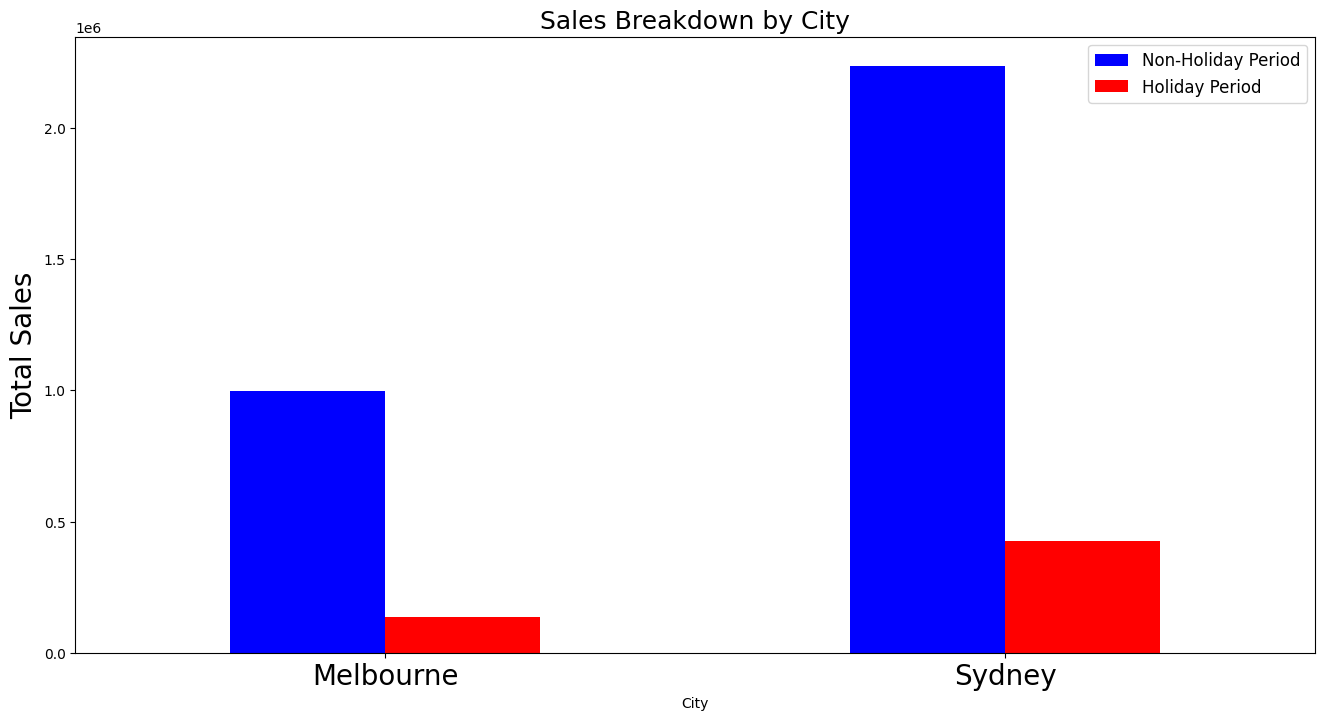

In [35]:
retail_data['Order Total'] = pd.to_numeric(retail_data['Order Total'].replace('[\$,]', '', regex=True))

#Sydney vs. Melbourne breakdown
city_holiday_sales = retail_data.groupby(['City', 'Is Holiday Period'])['Order Total'].sum().unstack()
city_holiday_sales.plot(kind='bar', stacked=False, figsize=(16, 8), color=['Blue', 'Red'])
plt.title('Sales Breakdown by City', fontsize=18)
plt.ylabel('Total Sales', fontsize=20)
plt.xticks(rotation=0, fontsize = 20)
plt.legend(['Non-Holiday Period', 'Holiday Period'], fontsize=12)
plt.show()

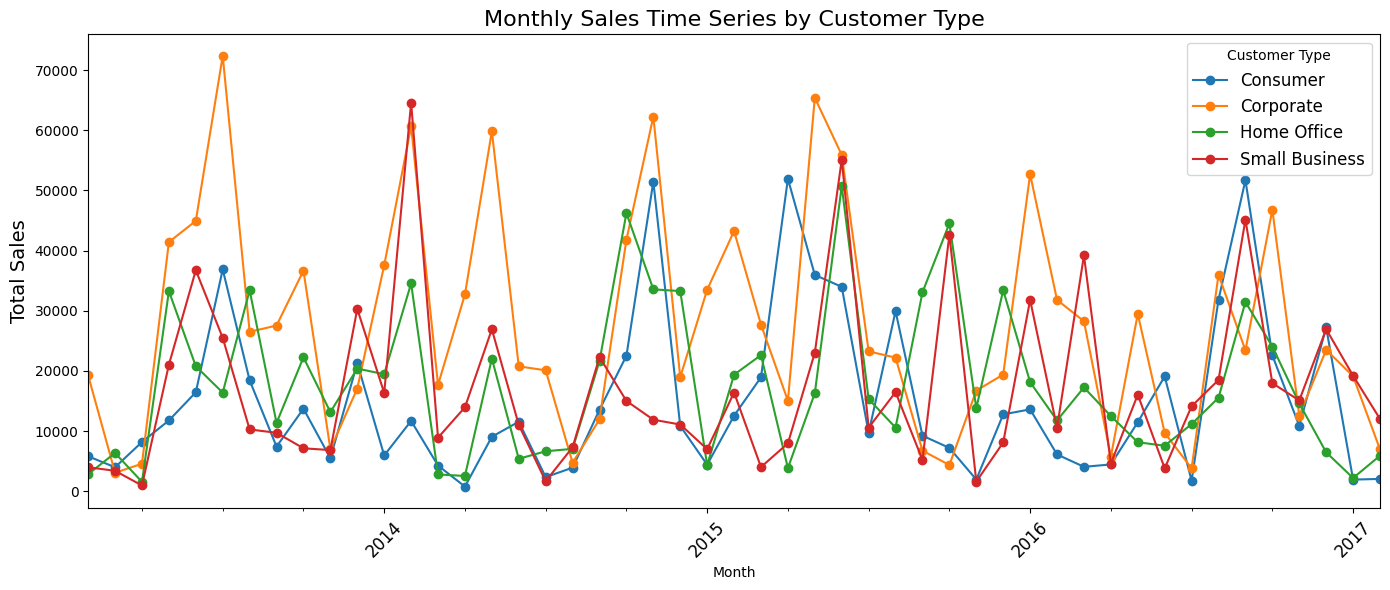

In [40]:
retail_data['Month'] = retail_data['Order Date'].dt.to_period('M')
monthly_trends = retail_data.groupby(['Month', 'Customer Type'])['Order Total'].sum().unstack()

monthly_trends.plot(kind='line', marker='o', figsize=(14, 6))
plt.title('Monthly Sales Time Series by Customer Type', fontsize=16)
plt.ylabel('Total Sales', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.legend(title='Customer Type', fontsize=12)
plt.tight_layout()
plt.show()

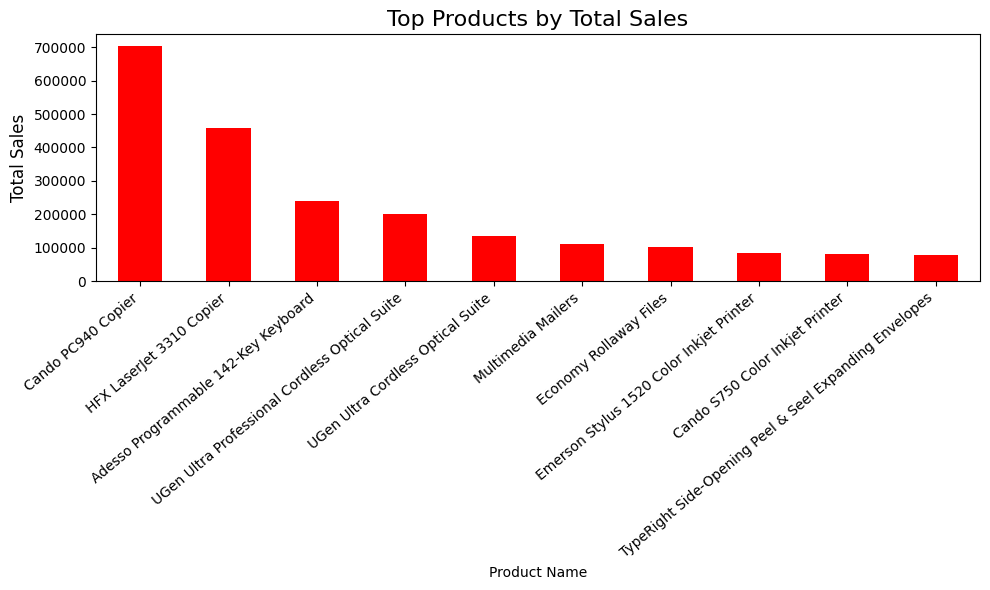

In [55]:
product_sales = retail_data.groupby('Product Name')['Order Total'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
product_sales.plot(kind='bar', color='red')
plt.title('Top Products by Total Sales', fontsize=16)
plt.ylabel('Total Sales', fontsize=12)
plt.xticks(rotation=40, ha='right')
plt.tight_layout()
plt.show()

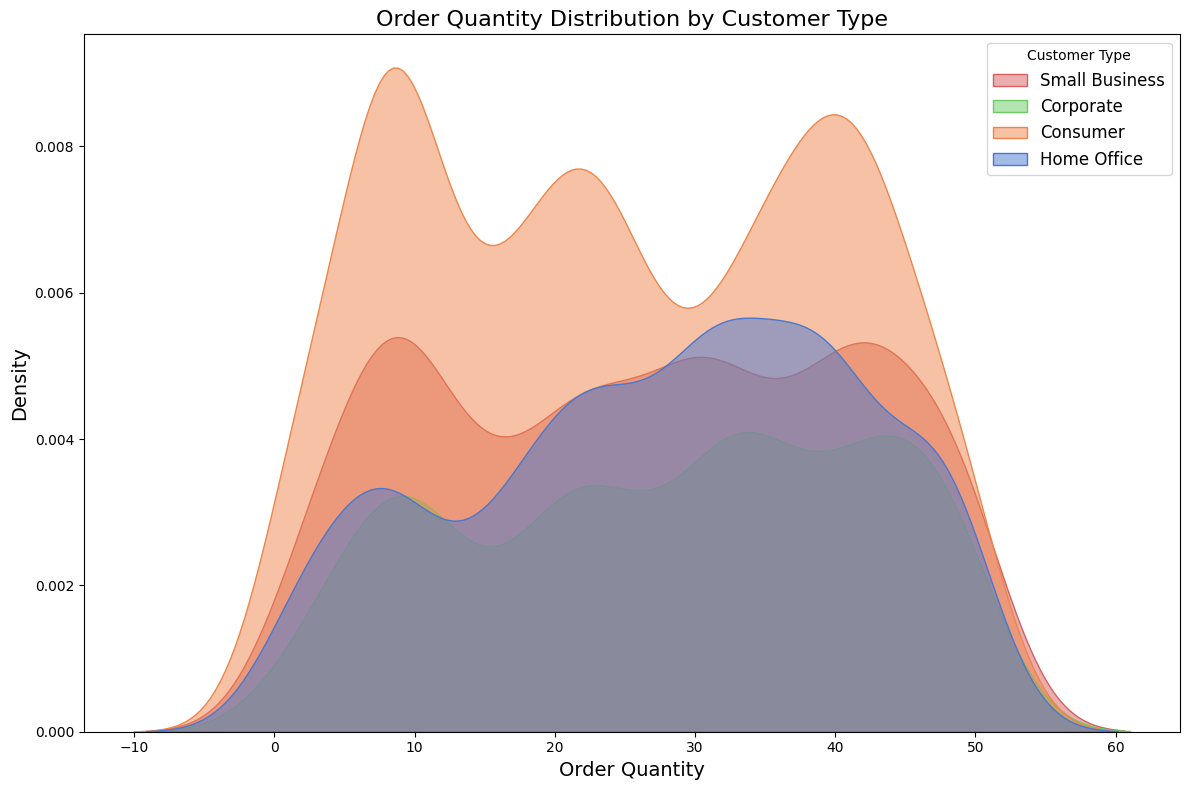

In [64]:
#distribution of order quantities by customer type

plt.figure(figsize=(12, 8))
sns.kdeplot(data=retail_data, x='Order Quantity', hue='Customer Type', fill=True, alpha=0.5, palette='muted')
plt.title('Order Quantity Distribution by Customer Type', fontsize=16)
plt.xlabel('Order Quantity', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend(['Small Business', 'Corporate', 'Consumer', 'Home Office'], title='Customer Type', fontsize=12)
plt.tight_layout()
plt.show()

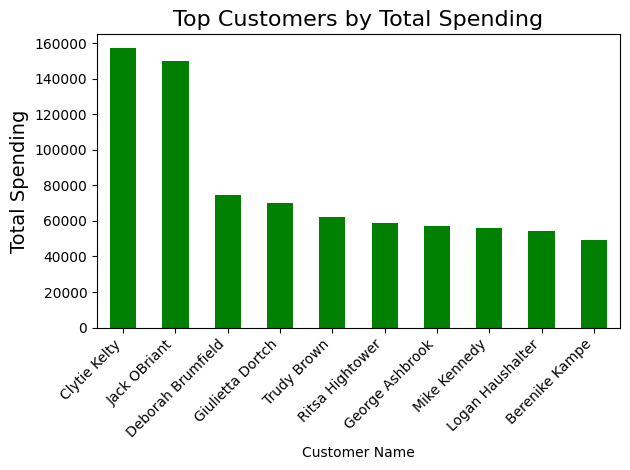

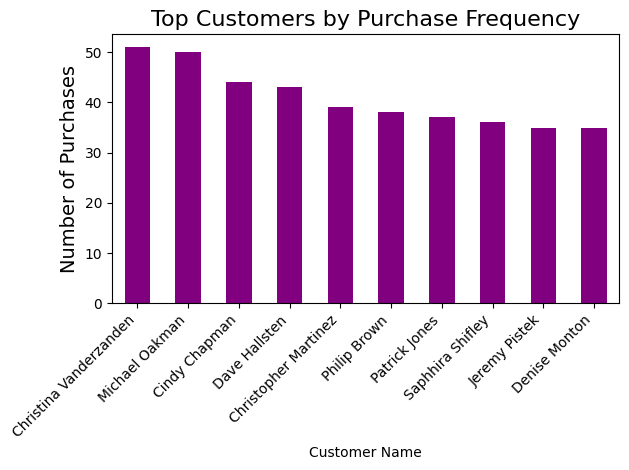

In [67]:
#Taking a look at some of the most frequent customers and the highest spenders

customer_spending = retail_data.groupby('Customer Name')['Order Total'].sum().sort_values(ascending=False).head(10)
customer_frequency = retail_data['Customer Name'].value_counts().head(10)

customer_spending.plot(kind='bar', color='green')
plt.title('Top Customers by Total Spending', fontsize=16)
plt.ylabel('Total Spending', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

customer_frequency.plot(kind='bar', color='purple')
plt.title('Top Customers by Purchase Frequency', fontsize=16)
plt.ylabel('Number of Purchases', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

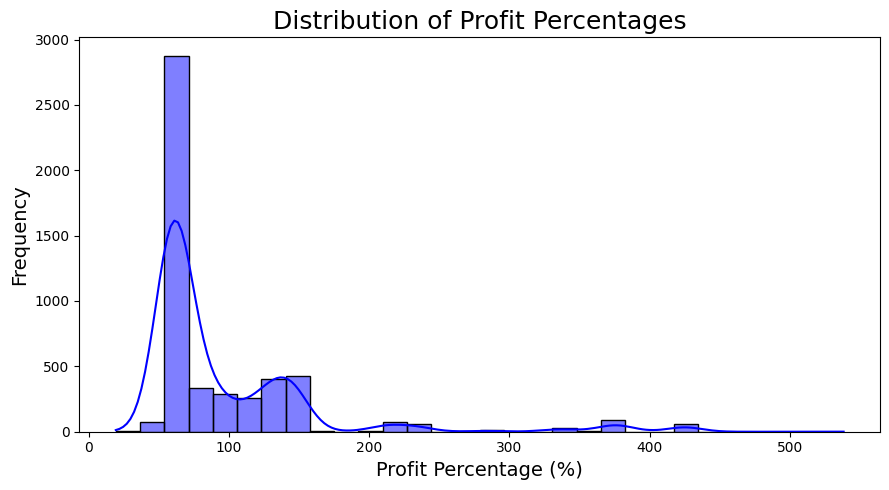

In [74]:
retail_data['Profit Margin'] = pd.to_numeric(retail_data['Profit Margin'].replace('[\$,]', '', regex=True), errors='coerce')
retail_data['Cost Price'] = pd.to_numeric(retail_data['Cost Price'].replace('[\$,]', '', regex=True), errors='coerce')
retail_data['Profit Percentage'] = (retail_data['Profit Margin'] / retail_data['Cost Price']) * 100

plt.figure(figsize=(9, 5))
sns.histplot(retail_data['Profit Percentage'], kde=True, bins=30, color='blue')
plt.title('Distribution of Profit Percentages', fontsize=18)
plt.xlabel('Profit Percentage (%)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.tight_layout()
plt.show()


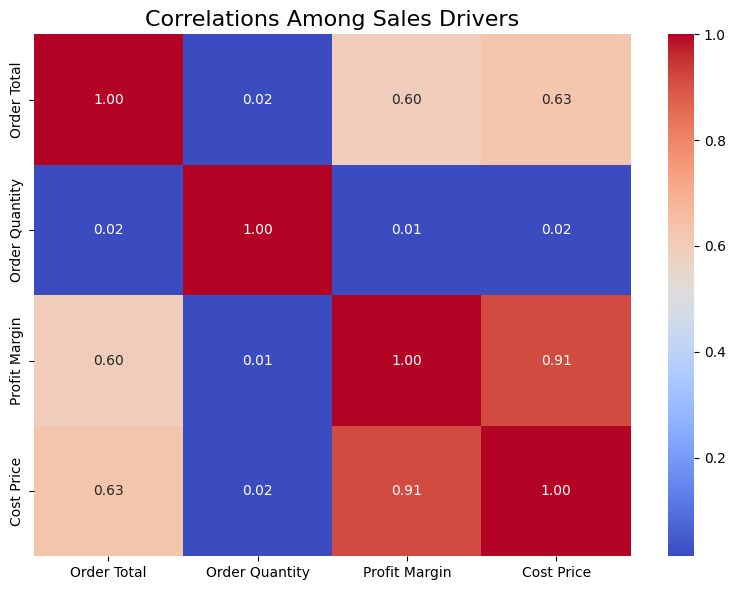

In [80]:
correlation_cols = retail_data[['Order Total', 'Order Quantity', 'Profit Margin', 'Cost Price']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_cols, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlations Among Sales Drivers', fontsize=16)
plt.tight_layout()
plt.show()

/Users/zachbecker/miniforge3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/zachbecker/miniforge3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/zachbecker/miniforge3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/zachbecker/miniforge3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_

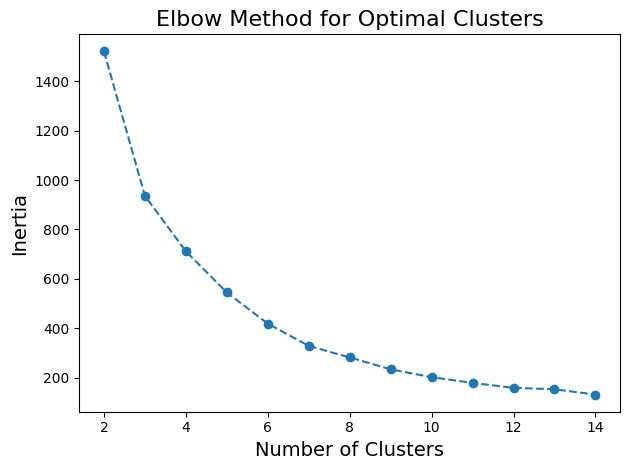

In [88]:
clustering_data = customer_metrics[['Avg Spend', 'Total Spend', 'Frequency']]

scaler = StandardScaler()
scaled_data = scaler.fit_transform(clustering_data)

#see what the inertias are for various numbers of clusters
inertias = []
for k in range(2, 15):
    kmeans = KMeans(n_clusters=k, random_state=4400)
    kmeans.fit(scaled_data)
    inertias.append(kmeans.inertia_)

#Elbow Method
plt.plot(range(2, 15), inertias, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal Clusters', fontsize=16)
plt.xlabel('Number of Clusters', fontsize=14)
plt.ylabel('Inertia', fontsize=14)
plt.tight_layout()
plt.show()

/Users/zachbecker/miniforge3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/zachbecker/miniforge3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/zachbecker/miniforge3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/zachbecker/miniforge3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_

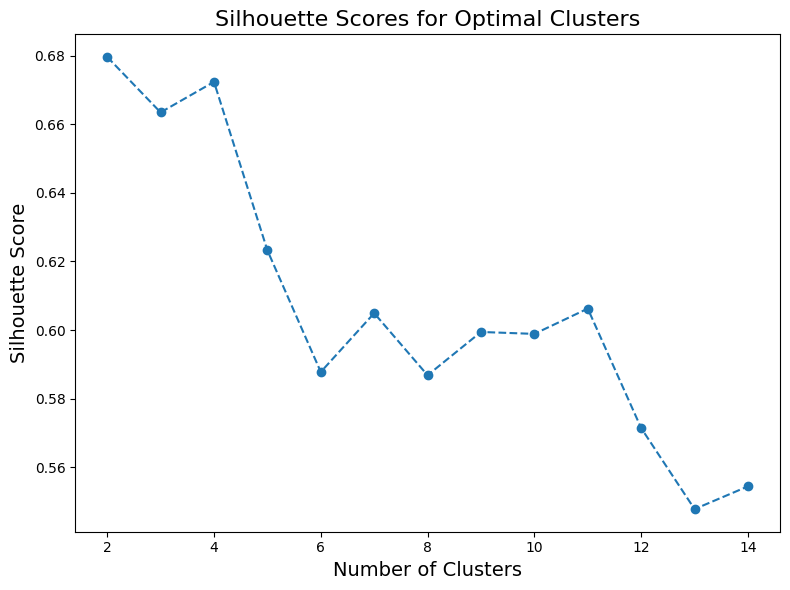

In [90]:
#determine the optimal number of clusters based on silhouette score

silhouette_scores = []
for k in range(2, 15):
    kmeans = KMeans(n_clusters=k, random_state=4400)
    kmeans.fit(scaled_data)
    silhouette_scores.append(silhouette_score(scaled_data, kmeans.labels_))

# Plot the Silhouette Score
plt.figure(figsize=(8, 6))
plt.plot(range(2, 15), silhouette_scores, marker='o', linestyle='--')
plt.title('Silhouette Scores for Optimal Clusters', fontsize=16)
plt.xlabel('Number of Clusters', fontsize=14)
plt.ylabel('Silhouette Score', fontsize=14)
plt.tight_layout()
plt.show()

/Users/zachbecker/miniforge3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


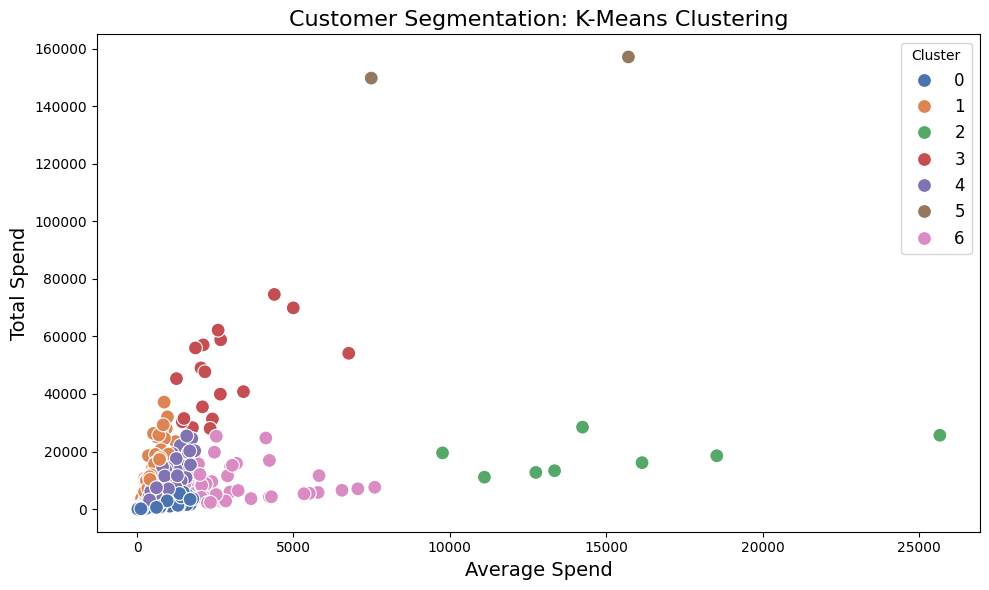

In [92]:
optimal_k = 7
kmeans = KMeans(n_clusters=optimal_k, random_state=4400)
customer_metrics['Cluster'] = kmeans.fit_predict(scaled_data)

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=customer_metrics, x='Avg Spend', y='Total Spend',
    hue='Cluster', palette='deep', s=100)
plt.title('Customer Segmentation: K-Means Clustering', fontsize=16)
plt.xlabel('Average Spend', fontsize=14)
plt.ylabel('Total Spend', fontsize=14)
plt.legend(title='Cluster', fontsize=12)
plt.tight_layout()
plt.show()

In [19]:
cluster_summary = customer_metrics.groupby('Cluster').agg({
    'Avg Spend': ['mean', 'std'],
    'Total Spend': ['mean', 'std'],
    'Frequency': ['mean', 'std'],
    'Customer Name': 'count'
}).rename(columns={'Customer Name': 'Cluster Size'})

cluster_summary

Avg Spend                 Total Spend                Frequency  \
                 mean          std           mean           std       mean   
Cluster                                                                      
0          593.462977   473.817714    6675.177434   5578.067708  11.572368   
1          478.918306   258.122071   13362.151833   8054.404000  27.833333   
2        15300.970556  4730.538713   17968.624444   5862.425072   1.222222   
3         2693.498387  1403.058412   46703.263333  14528.330403  19.500000   
4        11598.664500  5813.882159  153424.790000   5193.289186  15.000000   
5          261.232550   315.303469     557.567251    854.499323   2.055777   
6         3196.628056  1529.271942    8950.926591   6242.112647   3.295455   

                  Cluster Size  
              std        count  
Cluster                         
0        3.368341          152  
1        7.057072           60  
2        0.440959            9  
3        7.106335           18  
4        7.071068            2  
5        1.687360          502  
6        2.520424           44

In [93]:
# list of the products that aren't performing well
low_performing_products = retail_data.groupby('Product Name').agg({
    'Order Total': 'sum',
    'Profit Margin': 'mean'
}).query('`Order Total` < @retail_data["Order Total"].median()')


print("Low-Performing Products:\n", low_performing_products)

Low-Performing Products:
                                                     Order Total  Profit Margin
Product Name                                                                  
"Addiss Metal Binder Clips                                55.06           1.02
1 Stacking Storage Drawers                                26.63          13.85
1-, Tonkins Steel Grame                                   95.07           6.72
10 Colored Short Pencils                                  36.46           1.51
12 Colored Short                                          93.60          14.99
12 Colored Short Pencils with Erasers                     93.60           3.40
12 Ellic Surge Strip                                      93.60           6.43
13 Colored Short Pencils                                  39.74           1.51
186 Digital Answering Machine                             62.19          12.17
1Max Organizer Strips                                     62.99           2.00
3wax Printer              

In [114]:
low_product_categories = retail_data[retail_data['Product Name'].isin(low_performing_products.index)]\
.groupby('Product Category')['Order Total'].sum()

low_product_categories

Product Category
Furniture            10.10
Office Supplies    3243.92
Technology          857.38
Name: Order Total, dtype: float64

In [117]:
retail_data.to_csv('retailPulse.csv')